# Password Strength Classifier

This notebook demonstrates a simple machine learning project to classify passwords as weak, medium, or strong based on various features.


In [11]:
#Conda setup
#conda create -n pwclassifier python=3.11
#conda activate pwclassifier
#conda install -c conda-forge numpy pandas matplotlib seaborn scikit-learn jupyter

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re

np.random.seed(69)

In [13]:
def generate_password(min_length=4, max_length=20):
    lowercase = 'abcdefghijklmnopqrstuvwxyz'
    uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    digits = '0123456789'
    special = '!@#$%^&*()_+-=[]{}|;:,.<>?'
    
    complexity = np.random.choice(['simple', 'medium', 'complex'])
    
    if complexity == 'simple':
        length = np.random.randint(min_length, 10)
        chars = lowercase + digits
        pw_type = 0  #weak
    elif complexity == 'medium':
        length = np.random.randint(8, 12)
        chars = lowercase + uppercase + digits
        pw_type = 1  #medium
    else:
        length = np.random.randint(10, max_length)
        chars = lowercase + uppercase + digits + special
        pw_type = 2  #strong
    
    #Generate
    password = ''.join(np.random.choice(list(chars)) for _ in range(length))
    
    return password, pw_type

#Generate dataset
passwords = []
labels = []

for _ in range(1000):  #Generate 1000 passwords
    password, label = generate_password()
    passwords.append(password)
    labels.append(label)

df = pd.DataFrame({
    'password': passwords,
    'strength': labels
})

df['strength_category'] = df['strength'].map({0: 'weak', 1: 'medium', 2: 'strong'})

print(f"Dataset shape: {df.shape}")
df.sample(10)

Dataset shape: (1000, 3)


,password,strength,strength_category
18,5hdv,0,weak
951,NbEl0}AQQ|pZX,2,strong
500,aUjP{^@|0X,2,strong
659,jdlmd79,0,weak
842,53H8agpt0S];>$uAD,2,strong
436,C%|LzHZ*KJ&,2,strong
597,Pu;96gk1g[,2,strong
471,nxfd4i,0,weak
182,I)MdY&C5sn%KFI:N<d,2,strong
173,7qQDH?VnaM:fBJp|M,2,strong


In [14]:
def extract_features(password):
    features = {
        'length': len(password),
        'has_lowercase': int(bool(re.search(r'[a-z]', password))),
        'has_uppercase': int(bool(re.search(r'[A-Z]', password))),
        'has_digit': int(bool(re.search(r'\d', password))),
        'has_special': int(bool(re.search(r'[^a-zA-Z0-9]', password))),
        'count_lowercase': sum(1 for c in password if c.islower()),
        'count_uppercase': sum(1 for c in password if c.isupper()),
        'count_digits': sum(1 for c in password if c.isdigit()),
        'count_special': sum(1 for c in password if not c.isalnum())
    }
    return features

features_list = [extract_features(password) for password in df['password']]
features_df = pd.DataFrame(features_list)

df_with_features = pd.concat([df, features_df], axis=1)

df_with_features.sample(5)

,password,strength,strength_category,length,has_lowercase,has_uppercase,has_digit,has_special,count_lowercase,count_uppercase,count_digits,count_special
460,fSb)Kw&A.iC,2,strong,11,1,1,0,1,4,4,0,3
505,QaRax65lC,1,medium,9,1,1,1,0,4,3,2,0
51,"l|&72F,qWlZ+haW=",2,strong,16,1,1,1,1,5,4,2,5
269,okd9xbti,0,weak,8,1,0,1,0,7,0,1,0
681,ANvw1fAr4N,1,medium,10,1,1,1,0,4,4,2,0


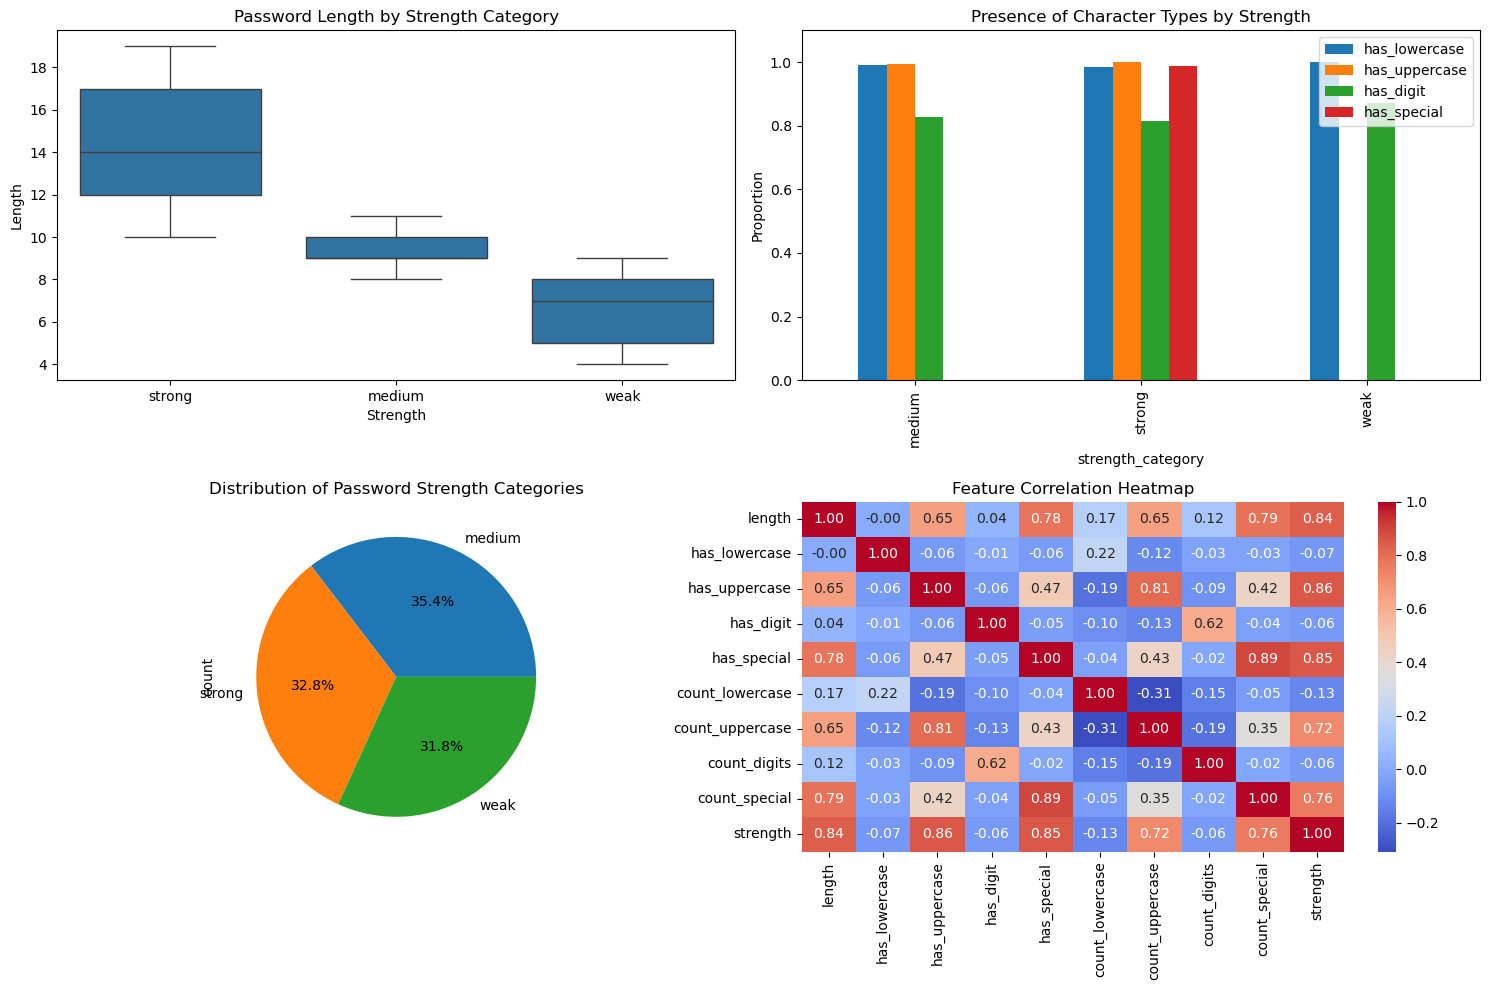

In [15]:
plt.figure(figsize=(15, 10))

#Distribution of password lengths by strength category
plt.subplot(2, 2, 1)
sns.boxplot(x='strength_category', y='length', data=df_with_features)
plt.title('Password Length by Strength Category')
plt.xlabel('Strength')
plt.ylabel('Length')

#Presence of character types by strength
plt.subplot(2, 2, 2)
character_types = df_with_features.groupby('strength_category')[
    ['has_lowercase', 'has_uppercase', 'has_digit', 'has_special']
].mean()
character_types.plot(kind='bar', ax=plt.gca())
plt.title('Presence of Character Types by Strength')
plt.ylabel('Proportion')
plt.ylim(0, 1.1)

#Count of passwords by strength category
plt.subplot(2, 2, 3)
df_with_features['strength_category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Password Strength Categories')

#Correlation heatmap
plt.subplot(2, 2, 4)
numeric_columns = ['length', 'has_lowercase', 'has_uppercase', 'has_digit', 'has_special', 
                  'count_lowercase', 'count_uppercase', 'count_digits', 'count_special', 'strength']
correlation = df_with_features[numeric_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

Training set size: 750
Testing set size: 250
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        weak       1.00      1.00      1.00        83
      medium       1.00      1.00      1.00        85
      strong       1.00      1.00      1.00        82

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



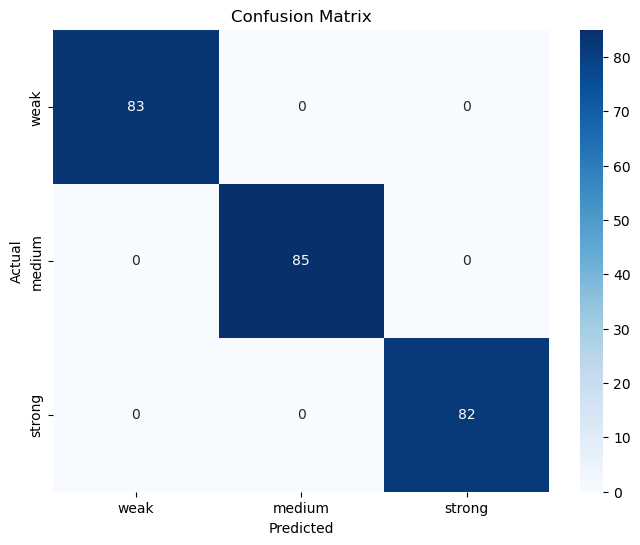

In [16]:
#Prepare feature and target variable
X = df_with_features[['length', 'has_lowercase', 'has_uppercase', 'has_digit', 'has_special',
                     'count_lowercase', 'count_uppercase', 'count_digits', 'count_special']]
y = df_with_features['strength']

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

#Init train rfc
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=69)
rf_classifier.fit(X_train, y_train)

#Test set predictions
y_pred = rf_classifier.predict(X_test)

#Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

#Classification
class_report = classification_report(y_test, y_pred, target_names=['weak', 'medium', 'strong'])
print("\nClassification Report:")
print(class_report)

#Show confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['weak', 'medium', 'strong'],
            yticklabels=['weak', 'medium', 'strong'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

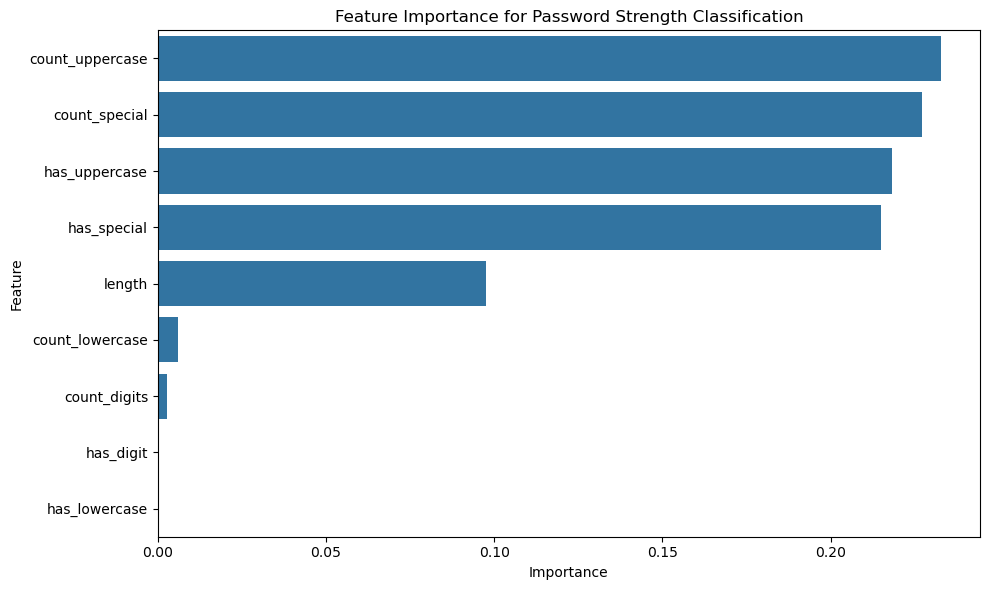

,Feature,Importance
6,count_uppercase,0.232787
8,count_special,0.227214
2,has_uppercase,0.218189
4,has_special,0.214999
0,length,0.097533
5,count_lowercase,0.006089
7,count_digits,0.002831
3,has_digit,0.000299
1,has_lowercase,0.000060


In [17]:
#Feature importances
feature_importances = rf_classifier.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

#Plot importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Password Strength Classification')
plt.tight_layout()
plt.show()

importance_df

In [18]:
#Test example passwords
test_passwords = [
    "password",
    "password123",
    "Pass123",
    "P@ssw0rd!",
    "abcdef",
    "Secure-P@ssw0rd-2025"
]

test_features = [extract_features(password) for password in test_passwords]
test_features_df = pd.DataFrame(test_features)

predictions = rf_classifier.predict(test_features_df)
prediction_probs = rf_classifier.predict_proba(test_features_df)

strength_mapping = {0: 'weak', 1: 'medium', 2: 'strong'}
predicted_strengths = [strength_mapping[pred] for pred in predictions]

results = pd.DataFrame({
    'Password': test_passwords,
    'Predicted Strength': predicted_strengths,
    'Weak Probability': prediction_probs[:, 0],
    'Medium Probability': prediction_probs[:, 1],
    'Strong Probability': prediction_probs[:, 2]
})

results

,Password,Predicted Strength,Weak Probability,Medium Probability,Strong Probability
0,password,weak,1.00,0.00,0.00
1,password123,weak,0.71,0.29,0.00
2,Pass123,medium,0.12,0.88,0.00
3,P@ssw0rd!,strong,0.00,0.02,0.98
4,abcdef,weak,1.00,0.00,0.00
5,Secure-P@ssw0rd-2025,strong,0.00,0.00,1.00


In [19]:
def check_password_strength(password, model):
    features = extract_features(password)
    features_df = pd.DataFrame([features])

    prediction = model.predict(features_df)[0]
    probabilities = model.predict_proba(features_df)[0]
    
    #Map
    strength_category = {0: 'weak', 1: 'medium', 2: 'strong'}[prediction]
    
    return {
        'password': password,
        'strength': strength_category,
        'probabilities': {
            'weak': probabilities[0],
            'medium': probabilities[1],
            'strong': probabilities[2]
        }
    }

#Custom Password
custom_password = input("Enter a password to check its strength: ")
result = check_password_strength(custom_password, rf_classifier)

print(f"\nPassword: {result['password']}")
print(f"Predicted Strength: {result['strength']}")
print("\nConfidence Scores:")
for category, prob in result['probabilities'].items():
    print(f"{category}: {prob:.2%}")


Password: tester
Predicted Strength: weak

Confidence Scores:
weak: 100.00%
medium: 0.00%
strong: 0.00%


## Conclusion

This project is simple machine learning model to classify passwords as weak, medium, or strong based on their characteristics in contrast/essence of my "pypasscheck" which is a simpler approach to password strength classification without the modeling.